In [2]:
!pip3 install xgboost
!pip3 install decision-tree-morfist
!pip3 install catboost

In [1]:
import config
import ast

import pandas as pd
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import statistics

from utils.pandas_dataframe import grid_display
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from itertools import permutations
import gc

# validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from morfist import MixedRandomForest
from catboost import CatBoostRegressor

# grid search
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.model_selection import GridSearchCV


from sklearn.multioutput import RegressorChain
from sklearn.multioutput import MultiOutputRegressor

from IPython.display import display


%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format',lambda x: '%.2f' % x)
# pd.set_option('display.max_rows', 5)
pd.set_option('display.max_rows', None)

In [3]:
data = pd.read_excel('../Data/2022-train-v2.xlsx')

In [4]:
print(f"train shape : {data.shape}")

train shape : (635, 131)


In [5]:
data_y = data[['sensor_point5_i_value', 'sensor_point6_i_value',\
               'sensor_point7_i_value', 'sensor_point8_i_value',\
               'sensor_point9_i_value', 'sensor_point10_i_value']]
data_x = data.drop(['sensor_point5_i_value', 'sensor_point6_i_value',\
                    'sensor_point7_i_value', 'sensor_point8_i_value',\
                    'sensor_point9_i_value', 'sensor_point10_i_value'], axis=1)

In [6]:
def Col_types(Data):
    Column_types = Data.dtypes.to_frame().reset_index()
    Column_types.columns = ['ColumnName', 'Type']
    Column_types.sort_values( by= 'Type', inplace = True)
    return Column_types

def Missing_Counts(Data):
    missing = Data.isnull().sum()
    missing = missing[ missing >0]
    missing.sort_values( inplace=True)
    Missing_Count = pd.DataFrame({ 'ColumnName':missing.index, 'MissingCount':missing.values})
    Missing_Count['Percentage(%)'] = Missing_Count['MissingCount'].apply(lambda x:round(x/Data.shape[0]*100,2))
    return Missing_Count

### 檢查缺失值

In [7]:
display(Missing_Counts(data_x))

,ColumnName,MissingCount,Percentage(%)
0,clean_ph4,286,45.04
1,clean_ph5,286,45.04
2,clean_ph7,286,45.04


In [8]:
display(Missing_Counts(data_y))

,ColumnName,MissingCount,Percentage(%)


In [9]:
data_x = data_x.fillna(0)

### 檢查資料屬性

In [10]:
display(Col_types(data_x))

,ColumnName,Type
0,clean_temp,float64
90,painting_g11_act_hvv,float64
89,painting_g11_act_t_air,float64
88,painting_g11_act_f_air,float64
87,painting_g11_act_a_air,float64
86,painting_g10_act_hvc,float64
85,painting_g10_act_hvv,float64
84,painting_g10_act_t_air,float64
83,painting_g10_act_f_air,float64
82,painting_g10_act_a_air,float64


# 1.X變數標準化

In [11]:
# X_train, X_test, Y_train, Y_test = train_test_split(data_x, data_y, train_size = 0.8, random_state = 3)

# X變數標準化
scaler = StandardScaler().fit(data_x)
data_x_S = scaler.transform(data_x)

# 2.迴圈計算每個Y在每個模型下的最佳超參數，並計算RMSE值

In [16]:
# 分別計算每個Model的最佳超參數及RMSE，以判斷6個 Y的最佳 Model
# model(含超參數設定)
Lasso_params_list = []
Ridge_params_list = []
XGB_params_list = []
KN_params_list = []
Ada_params_list = []
Cat_params_list = []

# K-fold RMSE
Lasso_RMSE = []
Ridge_RMSE = []
XGB_RMSE = []
KN_RMSE = []
Ada_RMSE = []
Cat_RMSE = []

Model_result = pd.DataFrame({})

for i in range(6):

# Gridsearch超參數範圍
  

# 1. Lasso_model
    config.Lassocv.fit(data_x_S, data_y.iloc[:,i])

    poly_Lasso_reg = Pipeline([('poly', PolynomialFeatures(degree = 2)),
                               ('std_scaler', StandardScaler()),
                               ('lasso_reg', Lasso(alpha = config.Lassocv.alpha_))
                              ])
    
    Lasso_params_list.append({'alpha':config.Lassocv.alpha_})
    
    # 訓練模型，計算train, test的RMSE
    Lasso_RMSE.append(-cross_val_score(poly_Lasso_reg, 
                                      data_x, data_y.iloc[:,i], 
                                      cv = 5, 
                                      scoring = 'neg_root_mean_squared_error').mean())
    
    poly_Lasso_reg.fit(data_x, data_y.iloc[:,i])
    

# 2. Ridge_model
    # Ridge超參數

    config.Ridgecv.fit(data_x_S, data_y.iloc[:,i])
    poly_Ridge_reg = Pipeline([('poly', PolynomialFeatures(degree = 2)),
                               ('std_scaler', StandardScaler()),
                               ('lasso_reg', Ridge(alpha = config.Ridgecv.alpha_))
                              ])
    
    Ridge_params_list.append({'alpha':config.Ridgecv.alpha_})
    
    # 訓練模型，計算train, test的RMSE
    Ridge_RMSE.append(-cross_val_score(poly_Ridge_reg, 
                                      data_x, data_y.iloc[:,i], 
                                      cv = 5, 
                                      scoring = 'neg_root_mean_squared_error').mean())
    
    poly_Ridge_reg.fit(data_x, data_y.iloc[:,i])

# 3. XGB_model
    # XGBM超參數
    config.grid_search_xgbm.fit(data_x_S, data_y.iloc[:,i])
    
    poly_XGB_reg = Pipeline([('poly',PolynomialFeatures(degree = 2)),
                            ('std_scaler', StandardScaler()),
                            ('xgb_reg', xgb.XGBRegressor(**config.grid_search_xgbm.best_params_))
                            ])
    
    XGB_params_list.append(config.grid_search_xgbm.best_params_)
    # 訓練模型，計算train, test的RMSE
    

    XGB_RMSE.append(-cross_val_score(poly_XGB_reg, 
                                    data_x, data_y.iloc[:,i], 
                                    cv = 5, 
                                    scoring = 'neg_root_mean_squared_error').mean())
    
    poly_XGB_reg.fit(data_x, data_y.iloc[:,i])


# 4. KN_model
    # KN超參數

    config.grid_search_KN.fit(data_x_S, data_y.iloc[:,i])

    poly_KN_reg = Pipeline([('poly',PolynomialFeatures(degree = 2)),
                        ('std_scaler', StandardScaler()),
                        ('KNR', KNeighborsRegressor(**config.grid_search_KN.best_params_))
                        ])
    
    KN_params_list.append(config.grid_search_KN.best_params_)
    # 訓練模型，計算train, test的RMSE
    
    KN_RMSE.append(-cross_val_score(poly_KN_reg, 
                                    data_x, data_y.iloc[:,i], 
                                    cv = 5, 
                                    scoring = 'neg_root_mean_squared_error').mean())
    
    poly_KN_reg.fit(data_x, data_y.iloc[:,i])    

# 5. Ada_model

    config.grid_search_Ada.fit(data_x_S, data_y.iloc[:,i])

    poly_Ada_reg = Pipeline([('poly',PolynomialFeatures(degree = 2)),
                             ('std_scaler', StandardScaler()),
                             ('Ada', AdaBoostRegressor(**config.grid_search_Ada.best_params_))
                            ]) 
    
    Ada_params_list.append(config.grid_search_Ada.best_params_)
    
    # 訓練模型，計算train, test的RMSE
    Ada_RMSE.append(-cross_val_score(poly_Ada_reg, 
                                     data_x, data_y.iloc[:,i], 
                                     cv = 5, 
                                     scoring = 'neg_root_mean_squared_error').mean())
    
    poly_Ada_reg.fit(data_x, data_y.iloc[:,i])        

    
# 6. Cat_model

    config.grid_search_Cat.fit(data_x_S, data_y.iloc[:,i])

    poly_Cat_reg = Pipeline([('poly',PolynomialFeatures(degree = 2)),
                             ('std_scaler', StandardScaler()),
                             ('Cat', CatBoostRegressor(**config.grid_search_Cat.best_params_))
                            ]) 
    
    Cat_params_list.append(config.grid_search_Cat.best_params_)
    
    # 訓練模型，計算train, test的RMSE
    Cat_RMSE.append(-cross_val_score(poly_Cat_reg, 
                                     data_x, data_y.iloc[:,i], 
                                     cv = 5, 
                                     scoring = 'neg_root_mean_squared_error').mean())
    
    poly_Cat_reg.fit(data_x, data_y.iloc[:,i])       

    
# **各模型預測結果放入Model_result
    
    Model_result['Actual_'+ data_y.columns.tolist()[i]] = data_y.iloc[:,i]
    Model_result['Lasso_'+ data_y.columns.tolist()[i]] = poly_Lasso_reg.predict(data_x)
    Model_result['Ridge_'+ data_y.columns.tolist()[i]] = poly_Ridge_reg.predict(data_x)
    Model_result['XGB_'+ data_y.columns.tolist()[i]] = poly_XGB_reg.predict(data_x)
    Model_result['KN_'+ data_y.columns.tolist()[i]] = poly_KN_reg.predict(data_x)
    Model_result['Ada_'+ data_y.columns.tolist()[i]] = poly_Ada_reg.predict(data_x)    
    Model_result['Cat_'+ data_y.columns.tolist()[i]] = poly_Cat_reg.predict(data_x)  
    
# list 串接成 pandas表格    
Model_RMSE = pd.DataFrame({'Lasso':Lasso_params_list,
                           'Lasso_RMSE':Lasso_RMSE,
                           'Ridge':Ridge_params_list,
                           'Ridge_RMSE':Ridge_RMSE,
                           'XGB':XGB_params_list,
                           'XGB_RMSE':XGB_RMSE,
                           'KN':KN_params_list,
                           'KN_RMSE':KN_RMSE,
                           'Ada':Ada_params_list,
                           'Ada_RMSE':Ada_RMSE,
                           'Cat':Cat_params_list,
                           'Cat_RMSE':Cat_RMSE
                          }, index = list(data_y.columns))

display(Model_RMSE)
display(Model_result)

# 資料輸出到Excel檔案
output = pd.ExcelWriter('../Data/output.xlsx')
Model_RMSE.to_excel(output, sheet_name = 'Model_RMSE',index = False)
Model_result.to_excel(output, sheet_name = 'Model_result',index = False)

output.save()

0:	learn: 12.8061145	total: 144ms	remaining: 28.6s
1:	learn: 12.3946000	total: 147ms	remaining: 14.5s
2:	learn: 12.1479984	total: 149ms	remaining: 9.8s
3:	learn: 11.8777513	total: 152ms	remaining: 7.43s
4:	learn: 11.5619842	total: 154ms	remaining: 6.02s
5:	learn: 11.3853554	total: 157ms	remaining: 5.08s
6:	learn: 11.2049888	total: 160ms	remaining: 4.41s
7:	learn: 11.0560220	total: 162ms	remaining: 3.89s
8:	learn: 10.8937247	total: 165ms	remaining: 3.5s
9:	learn: 10.7472428	total: 167ms	remaining: 3.18s
10:	learn: 10.6179696	total: 170ms	remaining: 2.92s
11:	learn: 10.5118472	total: 172ms	remaining: 2.7s
12:	learn: 10.3876118	total: 175ms	remaining: 2.52s
13:	learn: 10.2947885	total: 178ms	remaining: 2.36s
14:	learn: 10.1883326	total: 180ms	remaining: 2.22s
15:	learn: 10.0919736	total: 183ms	remaining: 2.1s
16:	learn: 9.9561584	total: 185ms	remaining: 2s
17:	learn: 9.8659031	total: 188ms	remaining: 1.9s
18:	learn: 9.7667303	total: 191ms	remaining: 1.81s
19:	learn: 9.7043594	total: 193ms

184:	learn: 6.8204577	total: 634ms	remaining: 51.4ms
185:	learn: 6.8134274	total: 637ms	remaining: 47.9ms
186:	learn: 6.8074129	total: 639ms	remaining: 44.5ms
187:	learn: 6.8021426	total: 643ms	remaining: 41ms
188:	learn: 6.7914415	total: 646ms	remaining: 37.6ms
189:	learn: 6.7888018	total: 648ms	remaining: 34.1ms
190:	learn: 6.7848850	total: 650ms	remaining: 30.6ms
191:	learn: 6.7767344	total: 653ms	remaining: 27.2ms
192:	learn: 6.7690671	total: 655ms	remaining: 23.8ms
193:	learn: 6.7646458	total: 658ms	remaining: 20.3ms
194:	learn: 6.7622525	total: 660ms	remaining: 16.9ms
195:	learn: 6.7563279	total: 662ms	remaining: 13.5ms
196:	learn: 6.7512953	total: 665ms	remaining: 10.1ms
197:	learn: 6.7457430	total: 668ms	remaining: 6.74ms
198:	learn: 6.7441220	total: 670ms	remaining: 3.37ms
199:	learn: 6.7354215	total: 673ms	remaining: 0us
0:	learn: 11.9529955	total: 148ms	remaining: 29.4s
1:	learn: 11.6243204	total: 234ms	remaining: 23.2s
2:	learn: 11.3175429	total: 331ms	remaining: 21.8s
3:	l

146:	learn: 6.3930891	total: 12.3s	remaining: 4.45s
147:	learn: 6.3871863	total: 12.5s	remaining: 4.38s
148:	learn: 6.3752008	total: 12.6s	remaining: 4.3s
149:	learn: 6.3674461	total: 12.7s	remaining: 4.23s
150:	learn: 6.3623088	total: 12.8s	remaining: 4.16s
151:	learn: 6.3548404	total: 12.9s	remaining: 4.07s
152:	learn: 6.3485851	total: 13s	remaining: 3.99s
153:	learn: 6.3405667	total: 13.1s	remaining: 3.91s
154:	learn: 6.3309965	total: 13.2s	remaining: 3.83s
155:	learn: 6.3216899	total: 13.3s	remaining: 3.76s
156:	learn: 6.3163471	total: 13.4s	remaining: 3.68s
157:	learn: 6.3085749	total: 13.5s	remaining: 3.59s
158:	learn: 6.2983869	total: 13.6s	remaining: 3.51s
159:	learn: 6.2891604	total: 13.7s	remaining: 3.42s
160:	learn: 6.2791849	total: 13.8s	remaining: 3.34s
161:	learn: 6.2740740	total: 13.9s	remaining: 3.25s
162:	learn: 6.2676161	total: 13.9s	remaining: 3.16s
163:	learn: 6.2622975	total: 14s	remaining: 3.08s
164:	learn: 6.2536640	total: 14.1s	remaining: 3s
165:	learn: 6.247385

108:	learn: 6.2609616	total: 7.66s	remaining: 6.39s
109:	learn: 6.2545390	total: 7.73s	remaining: 6.33s
110:	learn: 6.2367490	total: 7.8s	remaining: 6.26s
111:	learn: 6.2180930	total: 7.88s	remaining: 6.19s
112:	learn: 6.2038580	total: 7.95s	remaining: 6.12s
113:	learn: 6.1878071	total: 8.02s	remaining: 6.05s
114:	learn: 6.1772717	total: 8.09s	remaining: 5.98s
115:	learn: 6.1554850	total: 8.16s	remaining: 5.91s
116:	learn: 6.1400285	total: 8.23s	remaining: 5.84s
117:	learn: 6.1277064	total: 8.3s	remaining: 5.77s
118:	learn: 6.1170968	total: 8.37s	remaining: 5.7s
119:	learn: 6.1061397	total: 8.45s	remaining: 5.63s
120:	learn: 6.0980718	total: 8.53s	remaining: 5.57s
121:	learn: 6.0850403	total: 8.6s	remaining: 5.5s
122:	learn: 6.0740047	total: 8.68s	remaining: 5.43s
123:	learn: 6.0630182	total: 8.75s	remaining: 5.36s
124:	learn: 6.0544808	total: 8.82s	remaining: 5.29s
125:	learn: 6.0442429	total: 8.9s	remaining: 5.22s
126:	learn: 6.0257961	total: 8.97s	remaining: 5.16s
127:	learn: 6.0191

68:	learn: 7.7652219	total: 8.67s	remaining: 16.5s
69:	learn: 7.7442397	total: 8.78s	remaining: 16.3s
70:	learn: 7.7211510	total: 8.87s	remaining: 16.1s
71:	learn: 7.6928697	total: 8.96s	remaining: 15.9s
72:	learn: 7.6629267	total: 9.08s	remaining: 15.8s
73:	learn: 7.6411244	total: 9.19s	remaining: 15.7s
74:	learn: 7.6039342	total: 9.28s	remaining: 15.5s
75:	learn: 7.5845939	total: 9.38s	remaining: 15.3s
76:	learn: 7.5641402	total: 9.47s	remaining: 15.1s
77:	learn: 7.5457903	total: 9.57s	remaining: 15s
78:	learn: 7.5247634	total: 9.66s	remaining: 14.8s
79:	learn: 7.5061378	total: 9.76s	remaining: 14.6s
80:	learn: 7.4845389	total: 9.86s	remaining: 14.5s
81:	learn: 7.4690586	total: 9.96s	remaining: 14.3s
82:	learn: 7.4437423	total: 10.1s	remaining: 14.2s
83:	learn: 7.4280462	total: 10.2s	remaining: 14.1s
84:	learn: 7.4095364	total: 10.3s	remaining: 13.9s
85:	learn: 7.3907286	total: 10.4s	remaining: 13.7s
86:	learn: 7.3710215	total: 10.5s	remaining: 13.6s
87:	learn: 7.3494302	total: 10.6s

29:	learn: 8.7047879	total: 2.38s	remaining: 13.5s
30:	learn: 8.6544177	total: 2.44s	remaining: 13.3s
31:	learn: 8.6083769	total: 2.52s	remaining: 13.3s
32:	learn: 8.5773925	total: 2.59s	remaining: 13.1s
33:	learn: 8.5330406	total: 2.68s	remaining: 13.1s
34:	learn: 8.4853626	total: 2.75s	remaining: 13s
35:	learn: 8.4413850	total: 2.83s	remaining: 12.9s
36:	learn: 8.4044362	total: 2.9s	remaining: 12.8s
37:	learn: 8.3554503	total: 2.98s	remaining: 12.7s
38:	learn: 8.3211745	total: 3.06s	remaining: 12.6s
39:	learn: 8.2605717	total: 3.13s	remaining: 12.5s
40:	learn: 8.2233582	total: 3.2s	remaining: 12.4s
41:	learn: 8.2025147	total: 3.28s	remaining: 12.3s
42:	learn: 8.1669859	total: 3.36s	remaining: 12.3s
43:	learn: 8.1269835	total: 3.43s	remaining: 12.2s
44:	learn: 8.1082303	total: 3.51s	remaining: 12.1s
45:	learn: 8.0848434	total: 3.6s	remaining: 12s
46:	learn: 8.0575974	total: 3.68s	remaining: 12s
47:	learn: 8.0405923	total: 3.75s	remaining: 11.9s
48:	learn: 8.0214183	total: 3.83s	remain

190:	learn: 6.1552006	total: 15.4s	remaining: 727ms
191:	learn: 6.1508531	total: 15.5s	remaining: 646ms
192:	learn: 6.1427398	total: 15.6s	remaining: 567ms
193:	learn: 6.1397094	total: 15.8s	remaining: 487ms
194:	learn: 6.1359329	total: 15.9s	remaining: 407ms
195:	learn: 6.1305155	total: 16s	remaining: 326ms
196:	learn: 6.1272606	total: 16.1s	remaining: 245ms
197:	learn: 6.1247332	total: 16.2s	remaining: 163ms
198:	learn: 6.1203600	total: 16.3s	remaining: 81.8ms
199:	learn: 6.1171042	total: 16.4s	remaining: 0us
0:	learn: 12.8978252	total: 142ms	remaining: 28.3s
1:	learn: 12.4482364	total: 223ms	remaining: 22.1s
2:	learn: 12.1283661	total: 303ms	remaining: 19.9s
3:	learn: 11.8310162	total: 387ms	remaining: 19s
4:	learn: 11.5293487	total: 468ms	remaining: 18.3s
5:	learn: 11.2359545	total: 548ms	remaining: 17.7s
6:	learn: 10.9781534	total: 641ms	remaining: 17.7s
7:	learn: 10.7772761	total: 735ms	remaining: 17.6s
8:	learn: 10.6052063	total: 823ms	remaining: 17.5s
9:	learn: 10.4142867	total

152:	learn: 6.6425407	total: 13.2s	remaining: 4.07s
153:	learn: 6.6206087	total: 13.4s	remaining: 3.99s
154:	learn: 6.6079711	total: 13.5s	remaining: 3.9s
155:	learn: 6.6010799	total: 13.5s	remaining: 3.82s
156:	learn: 6.5945733	total: 13.6s	remaining: 3.73s
157:	learn: 6.5875648	total: 13.7s	remaining: 3.65s
158:	learn: 6.5831347	total: 13.8s	remaining: 3.56s
159:	learn: 6.5767469	total: 13.9s	remaining: 3.48s
160:	learn: 6.5716450	total: 14s	remaining: 3.39s
161:	learn: 6.5651882	total: 14.1s	remaining: 3.31s
162:	learn: 6.5601659	total: 14.2s	remaining: 3.22s
163:	learn: 6.5521551	total: 14.3s	remaining: 3.14s
164:	learn: 6.5469029	total: 14.4s	remaining: 3.05s
165:	learn: 6.5410528	total: 14.5s	remaining: 2.96s
166:	learn: 6.5357997	total: 14.6s	remaining: 2.88s
167:	learn: 6.5323870	total: 14.6s	remaining: 2.79s
168:	learn: 6.5219325	total: 14.8s	remaining: 2.71s
169:	learn: 6.5157949	total: 14.9s	remaining: 2.63s
170:	learn: 6.5121972	total: 15s	remaining: 2.54s
171:	learn: 6.507

115:	learn: 7.0342690	total: 8.86s	remaining: 6.41s
116:	learn: 7.0229220	total: 8.94s	remaining: 6.34s
117:	learn: 7.0094197	total: 9.02s	remaining: 6.27s
118:	learn: 6.9986781	total: 9.1s	remaining: 6.19s
119:	learn: 6.9886587	total: 9.17s	remaining: 6.12s
120:	learn: 6.9798856	total: 9.25s	remaining: 6.04s
121:	learn: 6.9687826	total: 9.32s	remaining: 5.96s
122:	learn: 6.9625176	total: 9.4s	remaining: 5.88s
123:	learn: 6.9502456	total: 9.47s	remaining: 5.81s
124:	learn: 6.9266469	total: 9.56s	remaining: 5.74s
125:	learn: 6.9181015	total: 9.63s	remaining: 5.66s
126:	learn: 6.9102334	total: 9.71s	remaining: 5.58s
127:	learn: 6.9002728	total: 9.79s	remaining: 5.5s
128:	learn: 6.8939728	total: 9.86s	remaining: 5.43s
129:	learn: 6.8832215	total: 9.94s	remaining: 5.35s
130:	learn: 6.8742121	total: 10s	remaining: 5.28s
131:	learn: 6.8638714	total: 10.1s	remaining: 5.2s
132:	learn: 6.8563822	total: 10.2s	remaining: 5.13s
133:	learn: 6.8490929	total: 10.3s	remaining: 5.05s
134:	learn: 6.8430

73:	learn: 11.6434983	total: 360ms	remaining: 614ms
74:	learn: 11.5894395	total: 365ms	remaining: 609ms
75:	learn: 11.5745329	total: 371ms	remaining: 605ms
76:	learn: 11.5468177	total: 376ms	remaining: 601ms
77:	learn: 11.5242633	total: 383ms	remaining: 598ms
78:	learn: 11.4700463	total: 388ms	remaining: 594ms
79:	learn: 11.4250514	total: 392ms	remaining: 588ms
80:	learn: 11.3959526	total: 397ms	remaining: 583ms
81:	learn: 11.3703735	total: 401ms	remaining: 577ms
82:	learn: 11.3522369	total: 406ms	remaining: 572ms
83:	learn: 11.3146684	total: 410ms	remaining: 566ms
84:	learn: 11.2701696	total: 415ms	remaining: 561ms
85:	learn: 11.2327579	total: 419ms	remaining: 555ms
86:	learn: 11.1958203	total: 423ms	remaining: 549ms
87:	learn: 11.1706047	total: 427ms	remaining: 544ms
88:	learn: 11.1539507	total: 432ms	remaining: 538ms
89:	learn: 11.1416502	total: 436ms	remaining: 533ms
90:	learn: 11.1167578	total: 440ms	remaining: 527ms
91:	learn: 11.0802556	total: 444ms	remaining: 522ms
92:	learn: 1

31:	learn: 13.7270609	total: 6.82s	remaining: 35.8s
32:	learn: 13.6412574	total: 7.03s	remaining: 35.6s
33:	learn: 13.5806637	total: 7.24s	remaining: 35.3s
34:	learn: 13.5115605	total: 7.44s	remaining: 35.1s
35:	learn: 13.4631291	total: 7.66s	remaining: 34.9s
36:	learn: 13.4032569	total: 7.86s	remaining: 34.6s
37:	learn: 13.3329686	total: 8.08s	remaining: 34.5s
38:	learn: 13.2568166	total: 8.29s	remaining: 34.2s
39:	learn: 13.1811250	total: 8.5s	remaining: 34s
40:	learn: 13.1051992	total: 8.71s	remaining: 33.8s
41:	learn: 13.0495900	total: 8.93s	remaining: 33.6s
42:	learn: 13.0097077	total: 9.13s	remaining: 33.4s
43:	learn: 12.9593456	total: 9.34s	remaining: 33.1s
44:	learn: 12.9172547	total: 9.55s	remaining: 32.9s
45:	learn: 12.8730071	total: 9.77s	remaining: 32.7s
46:	learn: 12.8193316	total: 9.99s	remaining: 32.5s
47:	learn: 12.7691084	total: 10.2s	remaining: 32.3s
48:	learn: 12.6801983	total: 10.4s	remaining: 32.1s
49:	learn: 12.6338149	total: 10.6s	remaining: 31.9s
50:	learn: 12.5

189:	learn: 9.8112279	total: 39.8s	remaining: 2.1s
190:	learn: 9.8062005	total: 40.1s	remaining: 1.89s
191:	learn: 9.8025849	total: 40.3s	remaining: 1.68s
192:	learn: 9.7974875	total: 40.5s	remaining: 1.47s
193:	learn: 9.7904873	total: 40.7s	remaining: 1.26s
194:	learn: 9.7841903	total: 40.9s	remaining: 1.05s
195:	learn: 9.7782974	total: 41.1s	remaining: 840ms
196:	learn: 9.7745699	total: 41.4s	remaining: 630ms
197:	learn: 9.7702488	total: 41.6s	remaining: 420ms
198:	learn: 9.7669783	total: 41.8s	remaining: 210ms
199:	learn: 9.7644003	total: 42.1s	remaining: 0us
0:	learn: 27.1120974	total: 276ms	remaining: 54.8s
1:	learn: 25.6754660	total: 497ms	remaining: 49.2s
2:	learn: 24.3216775	total: 732ms	remaining: 48.1s
3:	learn: 23.0681042	total: 956ms	remaining: 46.8s
4:	learn: 21.9811043	total: 1.18s	remaining: 46.2s
5:	learn: 20.9796486	total: 1.41s	remaining: 45.6s
6:	learn: 20.0005121	total: 1.65s	remaining: 45.4s
7:	learn: 19.1838371	total: 1.89s	remaining: 45.4s
8:	learn: 18.5153921	to

149:	learn: 9.5175069	total: 31s	remaining: 10.3s
150:	learn: 9.5043940	total: 31.2s	remaining: 10.1s
151:	learn: 9.4994316	total: 31.4s	remaining: 9.92s
152:	learn: 9.4930294	total: 31.6s	remaining: 9.71s
153:	learn: 9.4886552	total: 31.8s	remaining: 9.5s
154:	learn: 9.4837752	total: 32s	remaining: 9.29s
155:	learn: 9.4769793	total: 32.2s	remaining: 9.08s
156:	learn: 9.4710006	total: 32.4s	remaining: 8.87s
157:	learn: 9.4651985	total: 32.6s	remaining: 8.66s
158:	learn: 9.4588622	total: 32.8s	remaining: 8.45s
159:	learn: 9.4464280	total: 33s	remaining: 8.24s
160:	learn: 9.4401490	total: 33.2s	remaining: 8.04s
161:	learn: 9.4346979	total: 33.4s	remaining: 7.83s
162:	learn: 9.4294587	total: 33.6s	remaining: 7.62s
163:	learn: 9.4241534	total: 33.8s	remaining: 7.41s
164:	learn: 9.4199795	total: 34s	remaining: 7.2s
165:	learn: 9.4140000	total: 34.2s	remaining: 7s
166:	learn: 9.4049049	total: 34.4s	remaining: 6.79s
167:	learn: 9.4015678	total: 34.6s	remaining: 6.58s
168:	learn: 9.3938579	tot

109:	learn: 10.1893800	total: 22.6s	remaining: 18.5s
110:	learn: 10.1789042	total: 22.8s	remaining: 18.3s
111:	learn: 10.1579346	total: 23s	remaining: 18.1s
112:	learn: 10.1472556	total: 23.2s	remaining: 17.9s
113:	learn: 10.1303294	total: 23.4s	remaining: 17.7s
114:	learn: 10.1149207	total: 23.7s	remaining: 17.5s
115:	learn: 10.1026466	total: 23.9s	remaining: 17.3s
116:	learn: 10.0787136	total: 24.1s	remaining: 17.1s
117:	learn: 10.0643636	total: 24.3s	remaining: 16.9s
118:	learn: 10.0509696	total: 24.6s	remaining: 16.7s
119:	learn: 10.0369837	total: 24.8s	remaining: 16.5s
120:	learn: 10.0123329	total: 25s	remaining: 16.3s
121:	learn: 9.9994221	total: 25.2s	remaining: 16.1s
122:	learn: 9.9884262	total: 25.5s	remaining: 15.9s
123:	learn: 9.9774485	total: 25.7s	remaining: 15.7s
124:	learn: 9.9593395	total: 25.9s	remaining: 15.6s
125:	learn: 9.9510544	total: 26.1s	remaining: 15.4s
126:	learn: 9.9411880	total: 26.4s	remaining: 15.2s
127:	learn: 9.9363048	total: 26.6s	remaining: 15s
128:	l

68:	learn: 10.2404553	total: 13.5s	remaining: 25.6s
69:	learn: 10.2226550	total: 13.6s	remaining: 25.3s
70:	learn: 10.1896927	total: 13.8s	remaining: 25.1s
71:	learn: 10.1734384	total: 14s	remaining: 25s
72:	learn: 10.1295909	total: 14.2s	remaining: 24.8s
73:	learn: 10.0993882	total: 14.4s	remaining: 24.6s
74:	learn: 10.0797156	total: 14.6s	remaining: 24.4s
75:	learn: 10.0505680	total: 14.8s	remaining: 24.2s
76:	learn: 10.0296782	total: 15s	remaining: 24s
77:	learn: 10.0046941	total: 15.2s	remaining: 23.8s
78:	learn: 9.9828170	total: 15.4s	remaining: 23.6s
79:	learn: 9.9607426	total: 15.6s	remaining: 23.4s
80:	learn: 9.9338312	total: 15.8s	remaining: 23.2s
81:	learn: 9.9102714	total: 16s	remaining: 23s
82:	learn: 9.8752316	total: 16.2s	remaining: 22.8s
83:	learn: 9.8567511	total: 16.4s	remaining: 22.6s
84:	learn: 9.8238800	total: 16.6s	remaining: 22.4s
85:	learn: 9.7900757	total: 16.8s	remaining: 22.2s
86:	learn: 9.7674029	total: 17s	remaining: 22.1s
87:	learn: 9.7496756	total: 17.2s	r

28:	learn: 12.4360298	total: 7.11s	remaining: 42s
29:	learn: 12.3749360	total: 7.35s	remaining: 41.6s
30:	learn: 12.2974198	total: 7.58s	remaining: 41.3s
31:	learn: 12.2333943	total: 7.8s	remaining: 41s
32:	learn: 12.1280126	total: 8.03s	remaining: 40.6s
33:	learn: 12.0666930	total: 8.27s	remaining: 40.4s
34:	learn: 11.9722808	total: 8.5s	remaining: 40.1s
35:	learn: 11.8894861	total: 8.73s	remaining: 39.8s
36:	learn: 11.8219549	total: 8.96s	remaining: 39.5s
37:	learn: 11.7311177	total: 9.2s	remaining: 39.2s
38:	learn: 11.6776515	total: 9.43s	remaining: 38.9s
39:	learn: 11.6345436	total: 9.66s	remaining: 38.6s
40:	learn: 11.5750769	total: 9.89s	remaining: 38.3s
41:	learn: 11.5168275	total: 10.1s	remaining: 38.1s
42:	learn: 11.4671510	total: 10.4s	remaining: 37.8s
43:	learn: 11.4326838	total: 10.6s	remaining: 37.6s
44:	learn: 11.3864011	total: 10.8s	remaining: 37.3s
45:	learn: 11.3320282	total: 11.1s	remaining: 37.1s
46:	learn: 11.2864037	total: 11.3s	remaining: 36.9s
47:	learn: 11.24654

188:	learn: 8.6188719	total: 40.7s	remaining: 2.37s
189:	learn: 8.6162835	total: 40.9s	remaining: 2.15s
190:	learn: 8.6076601	total: 41.1s	remaining: 1.94s
191:	learn: 8.5997730	total: 41.3s	remaining: 1.72s
192:	learn: 8.5926261	total: 41.5s	remaining: 1.5s
193:	learn: 8.5900743	total: 41.7s	remaining: 1.29s
194:	learn: 8.5862593	total: 41.9s	remaining: 1.07s
195:	learn: 8.5782177	total: 42.1s	remaining: 859ms
196:	learn: 8.5672652	total: 42.3s	remaining: 644ms
197:	learn: 8.5638945	total: 42.5s	remaining: 429ms
198:	learn: 8.5610558	total: 42.7s	remaining: 215ms
199:	learn: 8.5589748	total: 42.9s	remaining: 0us
0:	learn: 26.6522552	total: 328ms	remaining: 1m 5s
1:	learn: 25.2615040	total: 560ms	remaining: 55.4s
2:	learn: 23.9543602	total: 802ms	remaining: 52.7s
3:	learn: 22.8893898	total: 1.04s	remaining: 50.9s
4:	learn: 21.8852845	total: 1.27s	remaining: 49.7s
5:	learn: 20.9568154	total: 1.52s	remaining: 49.3s
6:	learn: 20.0925868	total: 1.76s	remaining: 48.6s
7:	learn: 19.4157750	t

147:	learn: 9.6961890	total: 34.5s	remaining: 12.1s
148:	learn: 9.6890446	total: 34.7s	remaining: 11.9s
149:	learn: 9.6817706	total: 34.9s	remaining: 11.6s
150:	learn: 9.6728918	total: 35.1s	remaining: 11.4s
151:	learn: 9.6651522	total: 35.3s	remaining: 11.2s
152:	learn: 9.6563240	total: 35.6s	remaining: 10.9s
153:	learn: 9.6471382	total: 35.8s	remaining: 10.7s
154:	learn: 9.6430996	total: 36s	remaining: 10.5s
155:	learn: 9.6359497	total: 36.2s	remaining: 10.2s
156:	learn: 9.6286025	total: 36.4s	remaining: 9.98s
157:	learn: 9.6217409	total: 36.7s	remaining: 9.75s
158:	learn: 9.6078541	total: 36.9s	remaining: 9.51s
159:	learn: 9.5959845	total: 37.1s	remaining: 9.28s
160:	learn: 9.5902658	total: 37.3s	remaining: 9.04s
161:	learn: 9.5851555	total: 37.6s	remaining: 8.81s
162:	learn: 9.5765926	total: 37.8s	remaining: 8.58s
163:	learn: 9.5620171	total: 38s	remaining: 8.34s
164:	learn: 9.5571591	total: 38.2s	remaining: 8.11s
165:	learn: 9.5514024	total: 38.5s	remaining: 7.88s
166:	learn: 9.53

5:	learn: 22.3722701	total: 1.53s	remaining: 24s
6:	learn: 22.0393553	total: 1.77s	remaining: 23.5s
7:	learn: 21.5112205	total: 2s	remaining: 23s
8:	learn: 21.1926646	total: 2.23s	remaining: 22.5s
9:	learn: 20.9265205	total: 2.46s	remaining: 22.2s
10:	learn: 20.6230556	total: 2.69s	remaining: 21.8s
11:	learn: 20.3418696	total: 2.92s	remaining: 21.4s
12:	learn: 20.0743752	total: 3.15s	remaining: 21.1s
13:	learn: 19.8292163	total: 3.39s	remaining: 20.8s
14:	learn: 19.6608571	total: 3.62s	remaining: 20.5s
15:	learn: 19.4142023	total: 3.86s	remaining: 20.3s
16:	learn: 19.2404729	total: 4.09s	remaining: 20s
17:	learn: 19.0206469	total: 4.34s	remaining: 19.8s
18:	learn: 18.8844980	total: 4.57s	remaining: 19.5s
19:	learn: 18.6524146	total: 4.81s	remaining: 19.2s
20:	learn: 18.5565874	total: 5.04s	remaining: 19s
21:	learn: 18.5009840	total: 5.29s	remaining: 18.7s
22:	learn: 18.4140682	total: 5.52s	remaining: 18.5s
23:	learn: 18.3364810	total: 5.76s	remaining: 18.2s
24:	learn: 18.2099685	total:

66:	learn: 15.7762487	total: 14.3s	remaining: 7.07s
67:	learn: 15.7466525	total: 14.6s	remaining: 6.86s
68:	learn: 15.7306245	total: 14.8s	remaining: 6.65s
69:	learn: 15.7056652	total: 15s	remaining: 6.43s
70:	learn: 15.6407711	total: 15.2s	remaining: 6.22s
71:	learn: 15.6245850	total: 15.4s	remaining: 6s
72:	learn: 15.6054828	total: 15.6s	remaining: 5.78s
73:	learn: 15.5743613	total: 15.8s	remaining: 5.57s
74:	learn: 15.5530926	total: 16s	remaining: 5.35s
75:	learn: 15.5332651	total: 16.2s	remaining: 5.13s
76:	learn: 15.5121968	total: 16.5s	remaining: 4.91s
77:	learn: 15.4936534	total: 16.6s	remaining: 4.7s
78:	learn: 15.4775176	total: 16.9s	remaining: 4.48s
79:	learn: 15.4298408	total: 17.1s	remaining: 4.26s
80:	learn: 15.3537649	total: 17.3s	remaining: 4.05s
81:	learn: 15.3408721	total: 17.5s	remaining: 3.83s
82:	learn: 15.2865075	total: 17.7s	remaining: 3.62s
83:	learn: 15.2135932	total: 17.9s	remaining: 3.41s
84:	learn: 15.2033462	total: 18.1s	remaining: 3.19s
85:	learn: 15.151512

25:	learn: 15.8868037	total: 5.92s	remaining: 16.8s
26:	learn: 15.7770616	total: 6.15s	remaining: 16.6s
27:	learn: 15.6983994	total: 6.39s	remaining: 16.4s
28:	learn: 15.6621537	total: 6.62s	remaining: 16.2s
29:	learn: 15.5909718	total: 6.84s	remaining: 16s
30:	learn: 15.5493463	total: 7.06s	remaining: 15.7s
31:	learn: 15.4768100	total: 7.3s	remaining: 15.5s
32:	learn: 15.3861947	total: 7.54s	remaining: 15.3s
33:	learn: 15.3381769	total: 7.76s	remaining: 15.1s
34:	learn: 15.2804433	total: 7.99s	remaining: 14.8s
35:	learn: 15.2263266	total: 8.22s	remaining: 14.6s
36:	learn: 15.1806161	total: 8.47s	remaining: 14.4s
37:	learn: 15.1518288	total: 8.66s	remaining: 14.1s
38:	learn: 15.1036125	total: 8.84s	remaining: 13.8s
39:	learn: 15.0761467	total: 9s	remaining: 13.5s
40:	learn: 15.0128116	total: 9.18s	remaining: 13.2s
41:	learn: 14.9935102	total: 9.35s	remaining: 12.9s
42:	learn: 14.9661433	total: 9.53s	remaining: 12.6s
43:	learn: 14.9287039	total: 9.69s	remaining: 12.3s
44:	learn: 14.8792

84:	learn: 13.5248461	total: 18.4s	remaining: 3.25s
85:	learn: 13.5084828	total: 18.6s	remaining: 3.04s
86:	learn: 13.4436232	total: 18.9s	remaining: 2.82s
87:	learn: 13.3657456	total: 19.1s	remaining: 2.6s
88:	learn: 13.3308798	total: 19.3s	remaining: 2.38s
89:	learn: 13.3067574	total: 19.5s	remaining: 2.16s
90:	learn: 13.2579071	total: 19.7s	remaining: 1.95s
91:	learn: 13.2387194	total: 19.9s	remaining: 1.73s
92:	learn: 13.2056243	total: 20.1s	remaining: 1.51s
93:	learn: 13.1679809	total: 20.3s	remaining: 1.29s
94:	learn: 13.0889882	total: 20.5s	remaining: 1.08s
95:	learn: 13.0184838	total: 20.7s	remaining: 863ms
96:	learn: 12.9952253	total: 20.9s	remaining: 647ms
97:	learn: 12.9632520	total: 21.1s	remaining: 431ms
98:	learn: 12.9330437	total: 21.3s	remaining: 216ms
99:	learn: 12.8792767	total: 21.5s	remaining: 0us
0:	learn: 26.0497576	total: 316ms	remaining: 31.3s
1:	learn: 25.0948836	total: 512ms	remaining: 25.1s
2:	learn: 24.2249397	total: 725ms	remaining: 23.4s
3:	learn: 23.48036

73:	learn: 14.9888962	total: 375ms	remaining: 132ms
74:	learn: 14.9558790	total: 381ms	remaining: 127ms
75:	learn: 14.9341524	total: 385ms	remaining: 122ms
76:	learn: 14.8987185	total: 390ms	remaining: 117ms
77:	learn: 14.8779954	total: 395ms	remaining: 112ms
78:	learn: 14.8462160	total: 401ms	remaining: 107ms
79:	learn: 14.8167319	total: 406ms	remaining: 102ms
80:	learn: 14.7903875	total: 410ms	remaining: 96.2ms
81:	learn: 14.7697140	total: 414ms	remaining: 90.9ms
82:	learn: 14.7386256	total: 418ms	remaining: 85.6ms
83:	learn: 14.7184007	total: 422ms	remaining: 80.4ms
84:	learn: 14.7049340	total: 426ms	remaining: 75.2ms
85:	learn: 14.6826523	total: 430ms	remaining: 70ms
86:	learn: 14.6694362	total: 434ms	remaining: 64.8ms
87:	learn: 14.6458820	total: 438ms	remaining: 59.7ms
88:	learn: 14.6264387	total: 442ms	remaining: 54.6ms
89:	learn: 14.6122139	total: 446ms	remaining: 49.5ms
90:	learn: 14.5941194	total: 449ms	remaining: 44.5ms
91:	learn: 14.5725717	total: 453ms	remaining: 39.4ms
92

32:	learn: 18.1995307	total: 6.84s	remaining: 13.9s
33:	learn: 18.0784312	total: 7.05s	remaining: 13.7s
34:	learn: 17.9553098	total: 7.26s	remaining: 13.5s
35:	learn: 17.8345618	total: 7.48s	remaining: 13.3s
36:	learn: 17.7440779	total: 7.69s	remaining: 13.1s
37:	learn: 17.6422578	total: 7.91s	remaining: 12.9s
38:	learn: 17.5316097	total: 8.13s	remaining: 12.7s
39:	learn: 17.4400003	total: 8.35s	remaining: 12.5s
40:	learn: 17.3452946	total: 8.57s	remaining: 12.3s
41:	learn: 17.2456840	total: 8.78s	remaining: 12.1s
42:	learn: 17.1743295	total: 9s	remaining: 11.9s
43:	learn: 17.0906765	total: 9.23s	remaining: 11.7s
44:	learn: 17.0025385	total: 9.44s	remaining: 11.5s
45:	learn: 16.9333959	total: 9.65s	remaining: 11.3s
46:	learn: 16.8556577	total: 9.89s	remaining: 11.2s
47:	learn: 16.7697149	total: 10.1s	remaining: 10.9s
48:	learn: 16.7099342	total: 10.2s	remaining: 10.7s
49:	learn: 16.6238952	total: 10.4s	remaining: 10.4s
50:	learn: 16.5508404	total: 10.6s	remaining: 10.2s
51:	learn: 16.4

91:	learn: 14.9566146	total: 20.2s	remaining: 1.76s
92:	learn: 14.9350082	total: 20.4s	remaining: 1.54s
93:	learn: 14.9112372	total: 20.6s	remaining: 1.32s
94:	learn: 14.8830011	total: 20.8s	remaining: 1.1s
95:	learn: 14.8681221	total: 21.1s	remaining: 877ms
96:	learn: 14.8477679	total: 21.3s	remaining: 658ms
97:	learn: 14.8303521	total: 21.5s	remaining: 439ms
98:	learn: 14.8101729	total: 21.7s	remaining: 219ms
99:	learn: 14.7872418	total: 21.9s	remaining: 0us
0:	learn: 24.8976273	total: 263ms	remaining: 26s
1:	learn: 24.4246570	total: 460ms	remaining: 22.5s
2:	learn: 23.9861117	total: 670ms	remaining: 21.7s
3:	learn: 23.6040491	total: 869ms	remaining: 20.9s
4:	learn: 23.2260486	total: 1.07s	remaining: 20.4s
5:	learn: 22.8329109	total: 1.28s	remaining: 20.1s
6:	learn: 22.4591345	total: 1.49s	remaining: 19.8s
7:	learn: 22.1218024	total: 1.7s	remaining: 19.5s
8:	learn: 21.8297229	total: 1.93s	remaining: 19.5s
9:	learn: 21.4975810	total: 2.14s	remaining: 19.3s
10:	learn: 21.1805188	total:

51:	learn: 12.4395816	total: 11.9s	remaining: 11s
52:	learn: 12.4013053	total: 12.1s	remaining: 10.7s
53:	learn: 12.3554799	total: 12.3s	remaining: 10.5s
54:	learn: 12.3046697	total: 12.5s	remaining: 10.2s
55:	learn: 12.2631319	total: 12.7s	remaining: 10s
56:	learn: 12.2261670	total: 13s	remaining: 9.78s
57:	learn: 12.1911312	total: 13.2s	remaining: 9.53s
58:	learn: 12.1519051	total: 13.4s	remaining: 9.3s
59:	learn: 12.1135454	total: 13.6s	remaining: 9.05s
60:	learn: 12.0801694	total: 13.8s	remaining: 8.83s
61:	learn: 12.0409203	total: 14s	remaining: 8.59s
62:	learn: 11.9998600	total: 14.2s	remaining: 8.36s
63:	learn: 11.9494327	total: 14.4s	remaining: 8.12s
64:	learn: 11.9183284	total: 14.7s	remaining: 7.89s
65:	learn: 11.8830481	total: 14.9s	remaining: 7.66s
66:	learn: 11.8445728	total: 15.1s	remaining: 7.42s
67:	learn: 11.7993631	total: 15.3s	remaining: 7.2s
68:	learn: 11.7727819	total: 15.5s	remaining: 6.96s
69:	learn: 11.7498302	total: 15.7s	remaining: 6.73s
70:	learn: 11.7155498	

15:	learn: 17.2521325	total: 766ms	remaining: 8.81s
16:	learn: 17.0741044	total: 811ms	remaining: 8.73s
17:	learn: 16.9184997	total: 858ms	remaining: 8.67s
18:	learn: 16.7703822	total: 911ms	remaining: 8.68s
19:	learn: 16.6386117	total: 985ms	remaining: 8.87s
20:	learn: 16.4853902	total: 1.06s	remaining: 9.03s
21:	learn: 16.3310612	total: 1.11s	remaining: 9.02s
22:	learn: 16.2024131	total: 1.17s	remaining: 9.03s
23:	learn: 16.0639853	total: 1.23s	remaining: 9.05s
24:	learn: 15.9289861	total: 1.3s	remaining: 9.07s
25:	learn: 15.8033435	total: 1.35s	remaining: 9.03s
26:	learn: 15.6777288	total: 1.4s	remaining: 8.97s
27:	learn: 15.5591676	total: 1.45s	remaining: 8.9s
28:	learn: 15.4552406	total: 1.49s	remaining: 8.81s
29:	learn: 15.3378570	total: 1.54s	remaining: 8.73s
30:	learn: 15.2369864	total: 1.59s	remaining: 8.65s
31:	learn: 15.1429002	total: 1.63s	remaining: 8.57s
32:	learn: 15.0265320	total: 1.68s	remaining: 8.51s
33:	learn: 14.9407619	total: 1.73s	remaining: 8.43s
34:	learn: 14.8

173:	learn: 11.1794073	total: 8.41s	remaining: 1.26s
174:	learn: 11.1735444	total: 8.46s	remaining: 1.21s
175:	learn: 11.1692357	total: 8.5s	remaining: 1.16s
176:	learn: 11.1610965	total: 8.55s	remaining: 1.11s
177:	learn: 11.1521141	total: 8.6s	remaining: 1.06s
178:	learn: 11.1473121	total: 8.64s	remaining: 1.01s
179:	learn: 11.1401008	total: 8.69s	remaining: 966ms
180:	learn: 11.1316134	total: 8.74s	remaining: 917ms
181:	learn: 11.1222699	total: 8.79s	remaining: 869ms
182:	learn: 11.1096349	total: 8.84s	remaining: 821ms
183:	learn: 11.0957438	total: 8.88s	remaining: 773ms
184:	learn: 11.0874715	total: 8.94s	remaining: 725ms
185:	learn: 11.0808993	total: 8.98s	remaining: 676ms
186:	learn: 11.0730540	total: 9.03s	remaining: 628ms
187:	learn: 11.0660233	total: 9.07s	remaining: 579ms
188:	learn: 11.0616239	total: 9.12s	remaining: 531ms
189:	learn: 11.0550668	total: 9.17s	remaining: 483ms
190:	learn: 11.0479572	total: 9.22s	remaining: 434ms
191:	learn: 11.0424686	total: 9.27s	remaining: 3

127:	learn: 11.6814293	total: 5m 54s	remaining: 3m 19s
128:	learn: 11.6695051	total: 5m 56s	remaining: 3m 16s
129:	learn: 11.6598159	total: 5m 59s	remaining: 3m 13s
130:	learn: 11.6502601	total: 6m 1s	remaining: 3m 10s
131:	learn: 11.6355843	total: 6m 4s	remaining: 3m 7s
132:	learn: 11.6263352	total: 6m 7s	remaining: 3m 4s
133:	learn: 11.6161281	total: 6m 9s	remaining: 3m 2s
134:	learn: 11.6071001	total: 6m 12s	remaining: 2m 59s
135:	learn: 11.5921757	total: 6m 14s	remaining: 2m 56s
136:	learn: 11.5773331	total: 6m 17s	remaining: 2m 53s
137:	learn: 11.5706852	total: 6m 19s	remaining: 2m 50s
138:	learn: 11.5634588	total: 6m 22s	remaining: 2m 47s
139:	learn: 11.5484720	total: 6m 25s	remaining: 2m 45s
140:	learn: 11.5378709	total: 6m 27s	remaining: 2m 42s
141:	learn: 11.5174281	total: 6m 30s	remaining: 2m 39s
142:	learn: 11.5118551	total: 6m 33s	remaining: 2m 36s
143:	learn: 11.4980501	total: 6m 35s	remaining: 2m 33s
144:	learn: 11.4864214	total: 6m 38s	remaining: 2m 31s
145:	learn: 11.47

80:	learn: 12.7458578	total: 3m 41s	remaining: 5m 24s
81:	learn: 12.7172400	total: 3m 43s	remaining: 5m 21s
82:	learn: 12.6927181	total: 3m 46s	remaining: 5m 18s
83:	learn: 12.6723848	total: 3m 48s	remaining: 5m 16s
84:	learn: 12.6592897	total: 3m 51s	remaining: 5m 12s
85:	learn: 12.6321336	total: 3m 53s	remaining: 5m 10s
86:	learn: 12.5954976	total: 3m 56s	remaining: 5m 7s
87:	learn: 12.5789302	total: 3m 58s	remaining: 5m 4s
88:	learn: 12.5600821	total: 4m 1s	remaining: 5m 1s
89:	learn: 12.5409469	total: 4m 3s	remaining: 4m 58s
90:	learn: 12.5261996	total: 4m 6s	remaining: 4m 54s
91:	learn: 12.5085177	total: 4m 8s	remaining: 4m 51s
92:	learn: 12.4889461	total: 4m 11s	remaining: 4m 48s
93:	learn: 12.4704752	total: 4m 13s	remaining: 4m 45s
94:	learn: 12.4483506	total: 4m 15s	remaining: 4m 42s
95:	learn: 12.4359271	total: 4m 18s	remaining: 4m 39s
96:	learn: 12.4204800	total: 4m 20s	remaining: 4m 36s
97:	learn: 12.3976133	total: 4m 22s	remaining: 4m 33s
98:	learn: 12.3834054	total: 4m 24s

33:	learn: 14.9457012	total: 1m 37s	remaining: 7m 54s
34:	learn: 14.8361905	total: 1m 39s	remaining: 7m 49s
35:	learn: 14.7168018	total: 1m 42s	remaining: 7m 45s
36:	learn: 14.6267494	total: 1m 44s	remaining: 7m 41s
37:	learn: 14.5123522	total: 1m 47s	remaining: 7m 37s
38:	learn: 14.4249588	total: 1m 49s	remaining: 7m 33s
39:	learn: 14.3330776	total: 1m 52s	remaining: 7m 29s
40:	learn: 14.2512079	total: 1m 54s	remaining: 7m 25s
41:	learn: 14.1702443	total: 1m 57s	remaining: 7m 22s
42:	learn: 14.0823699	total: 2m	remaining: 7m 18s
43:	learn: 14.0133589	total: 2m 2s	remaining: 7m 15s
44:	learn: 13.9355062	total: 2m 5s	remaining: 7m 12s
45:	learn: 13.8597183	total: 2m 8s	remaining: 7m 9s
46:	learn: 13.7935257	total: 2m 11s	remaining: 7m 7s
47:	learn: 13.7246540	total: 2m 13s	remaining: 7m 3s
48:	learn: 13.6542613	total: 2m 16s	remaining: 6m 59s
49:	learn: 13.5846483	total: 2m 18s	remaining: 6m 55s
50:	learn: 13.5255020	total: 2m 22s	remaining: 6m 55s
51:	learn: 13.4684897	total: 2m 24s	re

185:	learn: 11.0149706	total: 8m 50s	remaining: 39.9s
186:	learn: 11.0068080	total: 8m 52s	remaining: 37s
187:	learn: 10.9995179	total: 8m 55s	remaining: 34.2s
188:	learn: 10.9935277	total: 8m 59s	remaining: 31.4s
189:	learn: 10.9910064	total: 9m 3s	remaining: 28.6s
190:	learn: 10.9835363	total: 9m 6s	remaining: 25.8s
191:	learn: 10.9798948	total: 9m 9s	remaining: 22.9s
192:	learn: 10.9758249	total: 9m 12s	remaining: 20s
193:	learn: 10.9669816	total: 9m 15s	remaining: 17.2s
194:	learn: 10.9590662	total: 9m 18s	remaining: 14.3s
195:	learn: 10.9544044	total: 9m 20s	remaining: 11.4s
196:	learn: 10.9494582	total: 9m 23s	remaining: 8.58s
197:	learn: 10.9467577	total: 9m 26s	remaining: 5.72s
198:	learn: 10.9366789	total: 9m 29s	remaining: 2.86s
199:	learn: 10.9318574	total: 9m 31s	remaining: 0us
0:	learn: 20.8353974	total: 2.74s	remaining: 9m 5s
1:	learn: 20.4953043	total: 5.81s	remaining: 9m 35s
2:	learn: 20.1572874	total: 8.71s	remaining: 9m 31s
3:	learn: 19.8454352	total: 11.3s	remaining:

138:	learn: 11.0923734	total: 5m 50s	remaining: 2m 33s
139:	learn: 11.0829404	total: 5m 53s	remaining: 2m 31s
140:	learn: 11.0756643	total: 5m 55s	remaining: 2m 28s
141:	learn: 11.0643949	total: 5m 58s	remaining: 2m 26s
142:	learn: 11.0544653	total: 6m	remaining: 2m 23s
143:	learn: 11.0458474	total: 6m 2s	remaining: 2m 21s
144:	learn: 11.0394560	total: 6m 5s	remaining: 2m 18s
145:	learn: 11.0304026	total: 6m 7s	remaining: 2m 16s
146:	learn: 11.0231292	total: 6m 10s	remaining: 2m 13s
147:	learn: 11.0162529	total: 6m 12s	remaining: 2m 10s
148:	learn: 11.0113176	total: 6m 15s	remaining: 2m 8s
149:	learn: 11.0022784	total: 6m 17s	remaining: 2m 5s
150:	learn: 10.9920347	total: 6m 20s	remaining: 2m 3s
151:	learn: 10.9873575	total: 6m 22s	remaining: 2m
152:	learn: 10.9760474	total: 6m 24s	remaining: 1m 58s
153:	learn: 10.9707151	total: 6m 27s	remaining: 1m 55s
154:	learn: 10.9645967	total: 6m 29s	remaining: 1m 53s
155:	learn: 10.9577601	total: 6m 32s	remaining: 1m 50s
156:	learn: 10.9506020	t

91:	learn: 10.4846653	total: 4m 26s	remaining: 5m 12s
92:	learn: 10.4543005	total: 4m 29s	remaining: 5m 9s
93:	learn: 10.4221102	total: 4m 31s	remaining: 5m 6s
94:	learn: 10.4082225	total: 4m 34s	remaining: 5m 3s
95:	learn: 10.3818149	total: 4m 37s	remaining: 5m
96:	learn: 10.3649030	total: 4m 40s	remaining: 4m 57s
97:	learn: 10.3433818	total: 4m 43s	remaining: 4m 54s
98:	learn: 10.3272306	total: 4m 46s	remaining: 4m 52s
99:	learn: 10.3100074	total: 4m 49s	remaining: 4m 49s
100:	learn: 10.2894041	total: 4m 52s	remaining: 4m 46s
101:	learn: 10.2720374	total: 4m 54s	remaining: 4m 43s
102:	learn: 10.2508190	total: 4m 57s	remaining: 4m 40s
103:	learn: 10.2346046	total: 5m	remaining: 4m 37s
104:	learn: 10.2072771	total: 5m 2s	remaining: 4m 34s
105:	learn: 10.1940524	total: 5m 5s	remaining: 4m 31s
106:	learn: 10.1780962	total: 5m 8s	remaining: 4m 27s
107:	learn: 10.1651900	total: 5m 11s	remaining: 4m 25s
108:	learn: 10.1528160	total: 5m 14s	remaining: 4m 22s
109:	learn: 10.1462126	total: 5m 

45:	learn: 13.7722757	total: 2m 36s	remaining: 8m 44s
46:	learn: 13.6995255	total: 2m 39s	remaining: 8m 40s
47:	learn: 13.6235147	total: 2m 43s	remaining: 8m 37s
48:	learn: 13.5603060	total: 2m 46s	remaining: 8m 33s
49:	learn: 13.5005964	total: 2m 50s	remaining: 8m 30s
50:	learn: 13.4363722	total: 2m 53s	remaining: 8m 27s
51:	learn: 13.3861304	total: 2m 56s	remaining: 8m 22s
52:	learn: 13.3273967	total: 2m 59s	remaining: 8m 18s
53:	learn: 13.2670214	total: 3m 3s	remaining: 8m 15s
54:	learn: 13.2187991	total: 3m 6s	remaining: 8m 12s
55:	learn: 13.1745180	total: 3m 10s	remaining: 8m 8s
56:	learn: 13.1255556	total: 3m 13s	remaining: 8m 4s
57:	learn: 13.0944034	total: 3m 16s	remaining: 8m 1s
58:	learn: 13.0394551	total: 3m 19s	remaining: 7m 57s
59:	learn: 12.9937095	total: 3m 23s	remaining: 7m 53s
60:	learn: 12.9456741	total: 3m 26s	remaining: 7m 51s
61:	learn: 12.9137305	total: 3m 30s	remaining: 7m 48s
62:	learn: 12.8725901	total: 3m 33s	remaining: 7m 44s
63:	learn: 12.8352926	total: 3m 3

196:	learn: 10.8761484	total: 11m 52s	remaining: 10.8s
197:	learn: 10.8686379	total: 11m 57s	remaining: 7.25s
198:	learn: 10.8571488	total: 12m 2s	remaining: 3.63s
199:	learn: 10.8504518	total: 12m 7s	remaining: 0us
0:	learn: 16.9264533	total: 18.3ms	remaining: 1.81s
1:	learn: 16.3996719	total: 37.7ms	remaining: 1.85s
2:	learn: 15.8753493	total: 53.7ms	remaining: 1.74s
3:	learn: 15.4493287	total: 67.8ms	remaining: 1.63s
4:	learn: 15.0599782	total: 84.3ms	remaining: 1.6s
5:	learn: 14.6616024	total: 99.9ms	remaining: 1.56s
6:	learn: 14.2573066	total: 115ms	remaining: 1.53s
7:	learn: 13.9255033	total: 130ms	remaining: 1.5s
8:	learn: 13.6708385	total: 146ms	remaining: 1.48s
9:	learn: 13.4442797	total: 164ms	remaining: 1.48s
10:	learn: 13.2803794	total: 182ms	remaining: 1.47s
11:	learn: 13.0841650	total: 199ms	remaining: 1.46s
12:	learn: 12.8509230	total: 217ms	remaining: 1.45s
13:	learn: 12.6584864	total: 232ms	remaining: 1.42s
14:	learn: 12.5170925	total: 246ms	remaining: 1.39s
15:	learn:

55:	learn: 10.5267021	total: 40.9s	remaining: 32.2s
56:	learn: 10.5048181	total: 41.6s	remaining: 31.4s
57:	learn: 10.4760964	total: 42.2s	remaining: 30.6s
58:	learn: 10.4581399	total: 43s	remaining: 29.9s
59:	learn: 10.4459988	total: 43.6s	remaining: 29.1s
60:	learn: 10.4148286	total: 44.3s	remaining: 28.3s
61:	learn: 10.3945698	total: 44.9s	remaining: 27.5s
62:	learn: 10.3688725	total: 45.6s	remaining: 26.8s
63:	learn: 10.3479319	total: 46.2s	remaining: 26s
64:	learn: 10.3370033	total: 46.9s	remaining: 25.3s
65:	learn: 10.3073698	total: 47.6s	remaining: 24.5s
66:	learn: 10.2955542	total: 48.2s	remaining: 23.8s
67:	learn: 10.2758548	total: 48.9s	remaining: 23s
68:	learn: 10.2493588	total: 49.6s	remaining: 22.3s
69:	learn: 10.2295884	total: 50.3s	remaining: 21.5s
70:	learn: 10.2233151	total: 50.9s	remaining: 20.8s
71:	learn: 10.1992293	total: 51.6s	remaining: 20.1s
72:	learn: 10.1817039	total: 52.3s	remaining: 19.3s
73:	learn: 10.1590962	total: 53.1s	remaining: 18.7s
74:	learn: 10.1372

16:	learn: 11.6278352	total: 11.5s	remaining: 56.1s
17:	learn: 11.4932772	total: 12.2s	remaining: 55.5s
18:	learn: 11.4103079	total: 12.9s	remaining: 54.9s
19:	learn: 11.3018739	total: 13.6s	remaining: 54.4s
20:	learn: 11.2050094	total: 14.3s	remaining: 53.7s
21:	learn: 11.0410054	total: 15s	remaining: 53s
22:	learn: 10.9651181	total: 15.7s	remaining: 52.4s
23:	learn: 10.8946405	total: 16.4s	remaining: 51.8s
24:	learn: 10.8199537	total: 17.1s	remaining: 51.2s
25:	learn: 10.7721013	total: 17.8s	remaining: 50.5s
26:	learn: 10.6505753	total: 18.5s	remaining: 49.9s
27:	learn: 10.6213114	total: 19.2s	remaining: 49.4s
28:	learn: 10.5356149	total: 19.9s	remaining: 48.8s
29:	learn: 10.4534138	total: 20.7s	remaining: 48.2s
30:	learn: 10.4021902	total: 21.4s	remaining: 47.7s
31:	learn: 10.3368808	total: 22.2s	remaining: 47.1s
32:	learn: 10.3012396	total: 22.8s	remaining: 46.3s
33:	learn: 10.2651368	total: 23.4s	remaining: 45.4s
34:	learn: 10.2123280	total: 24s	remaining: 44.6s
35:	learn: 10.1703

78:	learn: 8.1777899	total: 54s	remaining: 14.3s
79:	learn: 8.1626360	total: 54.9s	remaining: 13.7s
80:	learn: 8.1507162	total: 55.7s	remaining: 13.1s
81:	learn: 8.1365413	total: 56.4s	remaining: 12.4s
82:	learn: 8.1191948	total: 57.1s	remaining: 11.7s
83:	learn: 8.0976935	total: 57.9s	remaining: 11s
84:	learn: 8.0841184	total: 58.8s	remaining: 10.4s
85:	learn: 8.0705032	total: 59.7s	remaining: 9.72s
86:	learn: 8.0399714	total: 1m	remaining: 9.03s
87:	learn: 8.0114911	total: 1m 1s	remaining: 8.34s
88:	learn: 8.0012994	total: 1m 1s	remaining: 7.65s
89:	learn: 7.9691446	total: 1m 2s	remaining: 6.97s
90:	learn: 7.9564528	total: 1m 3s	remaining: 6.28s
91:	learn: 7.9429971	total: 1m 4s	remaining: 5.59s
92:	learn: 7.9250590	total: 1m 5s	remaining: 4.89s
93:	learn: 7.9075634	total: 1m 5s	remaining: 4.19s
94:	learn: 7.8971881	total: 1m 6s	remaining: 3.5s
95:	learn: 7.8730671	total: 1m 7s	remaining: 2.8s
96:	learn: 7.8572434	total: 1m 7s	remaining: 2.1s
97:	learn: 7.8493083	total: 1m 8s	remaini

38:	learn: 10.7419457	total: 32.4s	remaining: 50.7s
39:	learn: 10.6796536	total: 33.2s	remaining: 49.9s
40:	learn: 10.6178226	total: 34.1s	remaining: 49.1s
41:	learn: 10.5859431	total: 34.9s	remaining: 48.2s
42:	learn: 10.5601454	total: 35.7s	remaining: 47.4s
43:	learn: 10.5427182	total: 36.5s	remaining: 46.5s
44:	learn: 10.5110047	total: 37.3s	remaining: 45.6s
45:	learn: 10.4815645	total: 38.1s	remaining: 44.7s
46:	learn: 10.4502165	total: 38.9s	remaining: 43.9s
47:	learn: 10.4165894	total: 39.7s	remaining: 43s
48:	learn: 10.3853355	total: 40.5s	remaining: 42.2s
49:	learn: 10.3727562	total: 41.3s	remaining: 41.3s
50:	learn: 10.3233830	total: 42.1s	remaining: 40.5s
51:	learn: 10.3021378	total: 43s	remaining: 39.7s
52:	learn: 10.2647755	total: 43.8s	remaining: 38.9s
53:	learn: 10.2318838	total: 44.7s	remaining: 38.1s
54:	learn: 10.1896032	total: 45.5s	remaining: 37.2s
55:	learn: 10.1606255	total: 46.2s	remaining: 36.3s
56:	learn: 10.1265030	total: 46.9s	remaining: 35.4s
57:	learn: 10.08

,Lasso,Lasso_RMSE,Ridge,Ridge_RMSE,XGB,XGB_RMSE,KN,KN_RMSE,Ada,Ada_RMSE,Cat,Cat_RMSE
sensor_point5_i_value,{'alpha': 5.0},13.56,{'alpha': 500.0},17.63,"{'learning_rate': 0.2, 'max_depth': 5, 'min_ch...",14.82,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",14.35,"{'learning_rate': 0.2, 'n_estimators': 50}",13.90,"{'depth': 2, 'iterations': 200, 'l2_leaf_reg':...",16.06
sensor_point6_i_value,{'alpha': 1.0},29.61,{'alpha': 500.0},31.21,"{'learning_rate': 0.2, 'max_depth': 20, 'min_c...",25.79,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",31.24,"{'learning_rate': 0.2, 'n_estimators': 300}",27.46,"{'depth': 4, 'iterations': 200, 'l2_leaf_reg':...",26.79
sensor_point7_i_value,{'alpha': 1.0},27.46,{'alpha': 100.0},51.44,"{'learning_rate': 0.2, 'max_depth': 13, 'min_c...",25.26,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",25.38,"{'learning_rate': 0.2, 'n_estimators': 500}",26.24,"{'depth': 4, 'iterations': 100, 'l2_leaf_reg':...",24.60
sensor_point8_i_value,{'alpha': 1.0},26.11,{'alpha': 500.0},36.44,"{'learning_rate': 0.2, 'max_depth': 20, 'min_c...",23.92,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",23.26,"{'learning_rate': 0.5, 'n_estimators': 300}",22.88,"{'depth': 4, 'iterations': 100, 'l2_leaf_reg':...",23.02
sensor_point9_i_value,{'alpha': 500.0},22.14,{'alpha': 100.0},29.81,"{'learning_rate': 0.2, 'max_depth': 20, 'min_c...",21.89,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",20.57,"{'learning_rate': 0.2, 'n_estimators': 50}",22.32,"{'depth': 8, 'iterations': 200, 'l2_leaf_reg':...",20.92
sensor_point10_i_value,{'alpha': 1.0},23.79,{'alpha': 500.0},37.98,"{'learning_rate': 0.2, 'max_depth': 5, 'min_ch...",18.30,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",17.88,"{'learning_rate': 0.5, 'n_estimators': 50}",17.32,"{'depth': 6, 'iterations': 100, 'l2_leaf_reg':...",17.67


,Actual_sensor_point5_i_value,Lasso_sensor_point5_i_value,Ridge_sensor_point5_i_value,XGB_sensor_point5_i_value,KN_sensor_point5_i_value,Ada_sensor_point5_i_value,Cat_sensor_point5_i_value,Actual_sensor_point6_i_value,Lasso_sensor_point6_i_value,Ridge_sensor_point6_i_value,...,KN_sensor_point9_i_value,Ada_sensor_point9_i_value,Cat_sensor_point9_i_value,Actual_sensor_point10_i_value,Lasso_sensor_point10_i_value,Ridge_sensor_point10_i_value,XGB_sensor_point10_i_value,KN_sensor_point10_i_value,Ada_sensor_point10_i_value,Cat_sensor_point10_i_value
0,42,72.88,43.96,42.66,46.43,46.69,40.45,56,67.48,61.75,...,73.00,66.35,66.56,45,56.58,48.61,45.02,45.00,45.78,48.48
1,37,72.88,37.28,37.99,40.00,43.54,40.66,60,67.23,61.33,...,67.33,66.35,66.21,42,56.51,43.19,42.66,42.00,45.43,45.14
2,35,72.88,37.28,37.99,40.00,43.54,40.66,66,67.23,61.33,...,67.33,66.35,66.21,45,56.51,43.19,42.66,42.00,45.43,45.14
3,37,72.88,37.28,37.99,40.00,43.54,40.66,58,67.23,61.33,...,67.33,66.35,66.21,39,56.51,43.19,42.66,42.00,45.43,45.14
4,57,72.90,48.31,48.31,46.43,50.06,45.56,78,69.30,67.00,...,61.25,65.32,62.66,65,55.76,54.25,56.48,58.00,58.86,55.25
5,42,72.90,48.31,48.31,46.43,50.06,45.56,72,69.30,67.00,...,61.25,65.32,62.66,64,55.76,54.25,56.48,58.00,58.86,55.25
6,48,72.90,48.31,48.31,46.43,50.06,45.56,72,69.30,67.00,...,61.25,65.32,62.66,48,55.76,54.25,56.48,58.00,58.86,55.25
7,49,72.90,48.31,48.31,46.43,50.06,45.56,60,69.30,67.00,...,61.25,65.32,62.66,55,55.76,54.25,56.48,58.00,58.86,55.25
8,41,72.91,46.70,43.59,46.86,46.69,46.96,72,69.68,67.79,...,64.50,66.35,64.20,60,56.47,55.85,59.97,60.00,61.33,56.76
9,46,72.91,46.70,43.59,46.86,46.69,46.96,70,69.68,67.79,...,64.50,66.35,64.20,60,56.47,55.85,59.97,60.00,61.33,56.76


In [12]:
# 讀取結果檔案

Model_RMSE = pd.read_excel('../Data/output.xlsx','Model_RMSE')
Model_result = pd.read_excel('../Data/output.xlsx','Model_result')
Model_RMSE.index = [data_y.columns]
Model_RMSE

,Lasso,Lasso_RMSE,Ridge,Ridge_RMSE,XGB,XGB_RMSE,KN,KN_RMSE,Ada,Ada_RMSE,Cat,Cat_RMSE
sensor_point5_i_value,{'alpha': 5.0},13.56,{'alpha': 500.0},17.63,"{'learning_rate': 0.2, 'max_depth': 5, 'min_ch...",14.82,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",14.35,"{'learning_rate': 0.2, 'n_estimators': 50}",13.90,"{'depth': 2, 'iterations': 200, 'l2_leaf_reg':...",16.06
sensor_point6_i_value,{'alpha': 1.0},29.61,{'alpha': 500.0},31.21,"{'learning_rate': 0.2, 'max_depth': 20, 'min_c...",25.79,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",31.24,"{'learning_rate': 0.2, 'n_estimators': 300}",27.46,"{'depth': 4, 'iterations': 200, 'l2_leaf_reg':...",26.79
sensor_point7_i_value,{'alpha': 1.0},27.46,{'alpha': 100.0},51.44,"{'learning_rate': 0.2, 'max_depth': 13, 'min_c...",25.26,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",25.38,"{'learning_rate': 0.2, 'n_estimators': 500}",26.24,"{'depth': 4, 'iterations': 100, 'l2_leaf_reg':...",24.60
sensor_point8_i_value,{'alpha': 1.0},26.11,{'alpha': 500.0},36.44,"{'learning_rate': 0.2, 'max_depth': 20, 'min_c...",23.92,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",23.26,"{'learning_rate': 0.5, 'n_estimators': 300}",22.88,"{'depth': 4, 'iterations': 100, 'l2_leaf_reg':...",23.02
sensor_point9_i_value,{'alpha': 500.0},22.14,{'alpha': 100.0},29.81,"{'learning_rate': 0.2, 'max_depth': 20, 'min_c...",21.89,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",20.57,"{'learning_rate': 0.2, 'n_estimators': 50}",22.32,"{'depth': 8, 'iterations': 200, 'l2_leaf_reg':...",20.92
sensor_point10_i_value,{'alpha': 1.0},23.79,{'alpha': 500.0},37.98,"{'learning_rate': 0.2, 'max_depth': 5, 'min_ch...",18.30,"{'leaf_size': 20, 'n_neighbors': 7, 'weights':...",17.88,"{'learning_rate': 0.5, 'n_estimators': 50}",17.32,"{'depth': 6, 'iterations': 100, 'l2_leaf_reg':...",17.67


In [13]:
# 各Y變數依據k-fold計算的 RMSE挑選最佳的Model(RMSE最小)
for i in range(6):
    Y_var = Model_RMSE[list(map(lambda x: x + '_RMSE', config.model_name))].iloc[i,:]
    Y_var = Y_var[Y_var == Y_var.min()].index[0]
    print(data_y.columns[i] +'_best model:' + Y_var)

sensor_point5_i_value_best model:Lasso_RMSE
sensor_point6_i_value_best model:XGB_RMSE
sensor_point7_i_value_best model:Cat_RMSE
sensor_point8_i_value_best model:Ada_RMSE
sensor_point9_i_value_best model:KN_RMSE
sensor_point10_i_value_best model:Ada_RMSE


In [14]:
# 將最佳params轉成 dict型態

model_name = config.model_name
for m in model_name:
    # select model
    model_dict = Model_RMSE.loc[:,m].to_dict()
    for i in range(6):
        # 修改 key(如果資料匯入時index沒有帶入，將Key值轉為Y 變數欄位名稱)
        model_dict[data_y.columns[i]] = model_dict.pop(Model_RMSE.index[i])
        
        # 修改 value，將字串轉換成資料類型
        model_dict[data_y.columns[i]] = ast.literal_eval(model_dict[data_y.columns[i]])

    display('model:' + m, 'params:' + str(model_dict))

'model:Ridge'

"params:{'sensor_point5_i_value': {'alpha': 500.0}, 'sensor_point6_i_value': {'alpha': 500.0}, 'sensor_point7_i_value': {'alpha': 100.0}, 'sensor_point8_i_value': {'alpha': 500.0}, 'sensor_point9_i_value': {'alpha': 100.0}, 'sensor_point10_i_value': {'alpha': 500.0}}"

'model:Lasso'

"params:{'sensor_point5_i_value': {'alpha': 5.0}, 'sensor_point6_i_value': {'alpha': 1.0}, 'sensor_point7_i_value': {'alpha': 1.0}, 'sensor_point8_i_value': {'alpha': 1.0}, 'sensor_point9_i_value': {'alpha': 500.0}, 'sensor_point10_i_value': {'alpha': 1.0}}"

'model:XGB'

"params:{'sensor_point5_i_value': {'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 30}, 'sensor_point6_i_value': {'learning_rate': 0.2, 'max_depth': 20, 'min_child_weight': 10, 'n_estimators': 30}, 'sensor_point7_i_value': {'learning_rate': 0.2, 'max_depth': 13, 'min_child_weight': 10, 'n_estimators': 30}, 'sensor_point8_i_value': {'learning_rate': 0.2, 'max_depth': 20, 'min_child_weight': 3, 'n_estimators': 500}, 'sensor_point9_i_value': {'learning_rate': 0.2, 'max_depth': 20, 'min_child_weight': 3, 'n_estimators': 30}, 'sensor_point10_i_value': {'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 30}}"

'model:KN'

"params:{'sensor_point5_i_value': {'leaf_size': 20, 'n_neighbors': 7, 'weights': 'uniform'}, 'sensor_point6_i_value': {'leaf_size': 20, 'n_neighbors': 7, 'weights': 'distance'}, 'sensor_point7_i_value': {'leaf_size': 20, 'n_neighbors': 7, 'weights': 'distance'}, 'sensor_point8_i_value': {'leaf_size': 20, 'n_neighbors': 7, 'weights': 'uniform'}, 'sensor_point9_i_value': {'leaf_size': 20, 'n_neighbors': 7, 'weights': 'distance'}, 'sensor_point10_i_value': {'leaf_size': 20, 'n_neighbors': 7, 'weights': 'distance'}}"

'model:Ada'

"params:{'sensor_point5_i_value': {'learning_rate': 0.2, 'n_estimators': 50}, 'sensor_point6_i_value': {'learning_rate': 0.2, 'n_estimators': 300}, 'sensor_point7_i_value': {'learning_rate': 0.2, 'n_estimators': 500}, 'sensor_point8_i_value': {'learning_rate': 0.5, 'n_estimators': 300}, 'sensor_point9_i_value': {'learning_rate': 0.2, 'n_estimators': 50}, 'sensor_point10_i_value': {'learning_rate': 0.5, 'n_estimators': 50}}"

'model:Cat'

"params:{'sensor_point5_i_value': {'depth': 2, 'iterations': 200, 'l2_leaf_reg': 0.5, 'learning_rate': 0.1}, 'sensor_point6_i_value': {'depth': 4, 'iterations': 200, 'l2_leaf_reg': 0.5, 'learning_rate': 0.1}, 'sensor_point7_i_value': {'depth': 4, 'iterations': 100, 'l2_leaf_reg': 3, 'learning_rate': 0.1}, 'sensor_point8_i_value': {'depth': 4, 'iterations': 100, 'l2_leaf_reg': 0.2, 'learning_rate': 0.03}, 'sensor_point9_i_value': {'depth': 8, 'iterations': 200, 'l2_leaf_reg': 0.5, 'learning_rate': 0.03}, 'sensor_point10_i_value': {'depth': 6, 'iterations': 100, 'l2_leaf_reg': 0.5, 'learning_rate': 0.1}}"

# 3.迴圈計算不同排列順序下RMSE結果，最終得出最佳RMSE的順序

*參考RegressionChain(Regression只能放一個模型，而且不能調整超參數)，將先預測的Y值放入X，再預測下一個Y

In [ ]:
# 排列訓練模型，再計算全部Y變數的RMSE平均數。最佳排列結果取RMSE合計最小

check = 1000
order_list = []
predict_result_list = []
predict_result_avg = []

model_list = [Pipeline([('poly',PolynomialFeatures(degree = 2)),
                        ('std_scaler', StandardScaler()),
                        ('Ada', AdaBoostRegressor(**config.Ada_params[data_y.columns[0]]))
                        ]),
                       
              Pipeline([('poly',PolynomialFeatures(degree = 2)),
                        ('std_scaler', StandardScaler()),
                        ('xgb_reg', xgb.XGBRegressor(**config.XGB_params[data_y.columns[1]]))
                        ]),
              
              Pipeline([('poly',PolynomialFeatures(degree = 2)),
                        ('std_scaler', StandardScaler()),
                        ('xgb_reg', xgb.XGBRegressor(**config.XGB_params[data_y.columns[2]]))
                        ]),
              
              Pipeline([('poly',PolynomialFeatures(degree = 2)),
                        ('std_scaler', StandardScaler()),
                        ('Ada', AdaBoostRegressor(**config.Ada_params[data_y.columns[3]]))
                        ]),
               
              Pipeline([('poly',PolynomialFeatures(degree = 2)),
                        ('std_scaler', StandardScaler()),
                        ('KNR', KNeighborsRegressor(**config.KN_params[data_y.columns[4]]))
                        ]),
              
              Pipeline([('poly',PolynomialFeatures(degree = 2)),
                        ('std_scaler', StandardScaler()),
                        ('Ada', AdaBoostRegressor(**config.Ada_params[data_y.columns[3]]))
                        ])
              ]

# 取得排列 0~6清單
for i in list(permutations(range(6),6)):
    Model_RMSE = []
    X_PT = data_x
    
    # 按照排列順序訓練模型，計算RMSE
    for k in range(6):
        model = model_list[list(i)[k]]
        model.fit(X_PT, data_y.iloc[:,list(i)[k]])
        
        # k_fold RMSE
        Model_RMSE.append(-cross_val_score(model, 
                                           X_PT, data_y.iloc[:,list(i)[k]], 
                                           cv = 5, 
                                           scoring = 'neg_root_mean_squared_error').mean())
        
        # 把取得的預測值當作變數放進X
        X_PT[data_y.iloc[:,[0]].columns[0]+'_predict'] = model.predict(X_PT)


    order_list.append(''.join(str(list(i))))
    
    # 平均6個Y變數計算的RMSE
    predict_result_avg.append(statistics.mean(Model_RMSE))
    
    # 個別6個Y變數的RMSE
    predict_result_list.append(str(Model_RMSE))
    
    if statistics.mean(Model_RMSE) < check:
        check = statistics.mean(Model_RMSE)
        order_list_fn = str(list(i))


Order_result = pd.DataFrame({ 'Group':order_list,
                              'predict_result_avg':predict_result_avg,
                              'predict_result_list':predict_result_list})

display('best model list:' + order_list_fn)
display(Order_result)

### 最佳順序為[5, 3, 2, 1, 4, 0]，透過最佳順序計算RMSE

In [15]:
# order_list 迴圈後得出的最佳順序；model_list 各變數引用的模型

def Regression_Chain_Y(order_list, model_list):
    Model_RMSE = []
    RMSE_num = []
    X_PT = data_x
    for k in range(6):
        # 按照排列順序訓練模型
        model = model_list[order_list[k]]
        model.fit(X_PT, data_y.iloc[:,order_list[k]])
        
        # RMSE(train、test)
        
        RMSE_val = round(-cross_val_score(model, \
                                          X_PT, \
                                          data_y.iloc[:,order_list[k]], \
                                          cv = 5, \
                                          scoring = 'neg_root_mean_squared_error').mean(),2)
        
        
        Model_RMSE.append(data_y.columns[order_list[k]] + '_RMSE:' + str(RMSE_val))
        
        RMSE_num.append(RMSE_val)
        
        # 把取得的預測值當作變數放進X(train, test)
        X_PT[data_y.iloc[:,[0]].columns[0]+'_predict'] = model.predict(X_PT)

    # 全部Model RMSE取平均
    RMSE_avg = statistics.mean(RMSE_num)
    return RMSE_avg, Model_RMSE

In [16]:
# 設定 model順序(按Y變數順序排列)

model_list = [Pipeline([('poly',PolynomialFeatures(degree = 2)),
                        ('std_scaler', StandardScaler()),
                        ('Ada', AdaBoostRegressor(**config.Ada_params[data_y.columns[0]]))
                        ]),
                       
              Pipeline([('poly',PolynomialFeatures(degree = 2)),
                        ('std_scaler', StandardScaler()),
                        ('xgb_reg', xgb.XGBRegressor(**config.XGB_params[data_y.columns[1]]))
                        ]),
              
              Pipeline([('poly',PolynomialFeatures(degree = 2)),
                        ('std_scaler', StandardScaler()),
                        ('xgb_reg', xgb.XGBRegressor(**config.XGB_params[data_y.columns[2]]))
                        ]),
              
              Pipeline([('poly',PolynomialFeatures(degree = 2)),
                        ('std_scaler', StandardScaler()),
                        ('Ada', AdaBoostRegressor(**config.Ada_params[data_y.columns[3]]))
                        ]),
               
              Pipeline([('poly',PolynomialFeatures(degree = 2)),
                        ('std_scaler', StandardScaler()),
                        ('KNR', KNeighborsRegressor(**config.KN_params[data_y.columns[4]]))
                        ]),
              
              Pipeline([('poly',PolynomialFeatures(degree = 2)),
                        ('std_scaler', StandardScaler()),
                        ('Ada', AdaBoostRegressor(**config.Ada_params[data_y.columns[3]]))
                        ])
              ]

RMSE_avg, Model_RMSE = Regression_Chain_Y(config.order_list, model_list)

print('RMSE_avg:' + str(RMSE_avg),'\n\nY_variable_RMSE:' + str(Model_RMSE))

RMSE_avg:21.171666666666667 

Y_variable_RMSE:['sensor_point10_i_value_RMSE:17.41', 'sensor_point8_i_value_RMSE:22.69', 'sensor_point7_i_value_RMSE:26.63', 'sensor_point6_i_value_RMSE:25.78', 'sensor_point9_i_value_RMSE:20.43', 'sensor_point5_i_value_RMSE:14.09']


# 4.計算實際值跟預測值差異

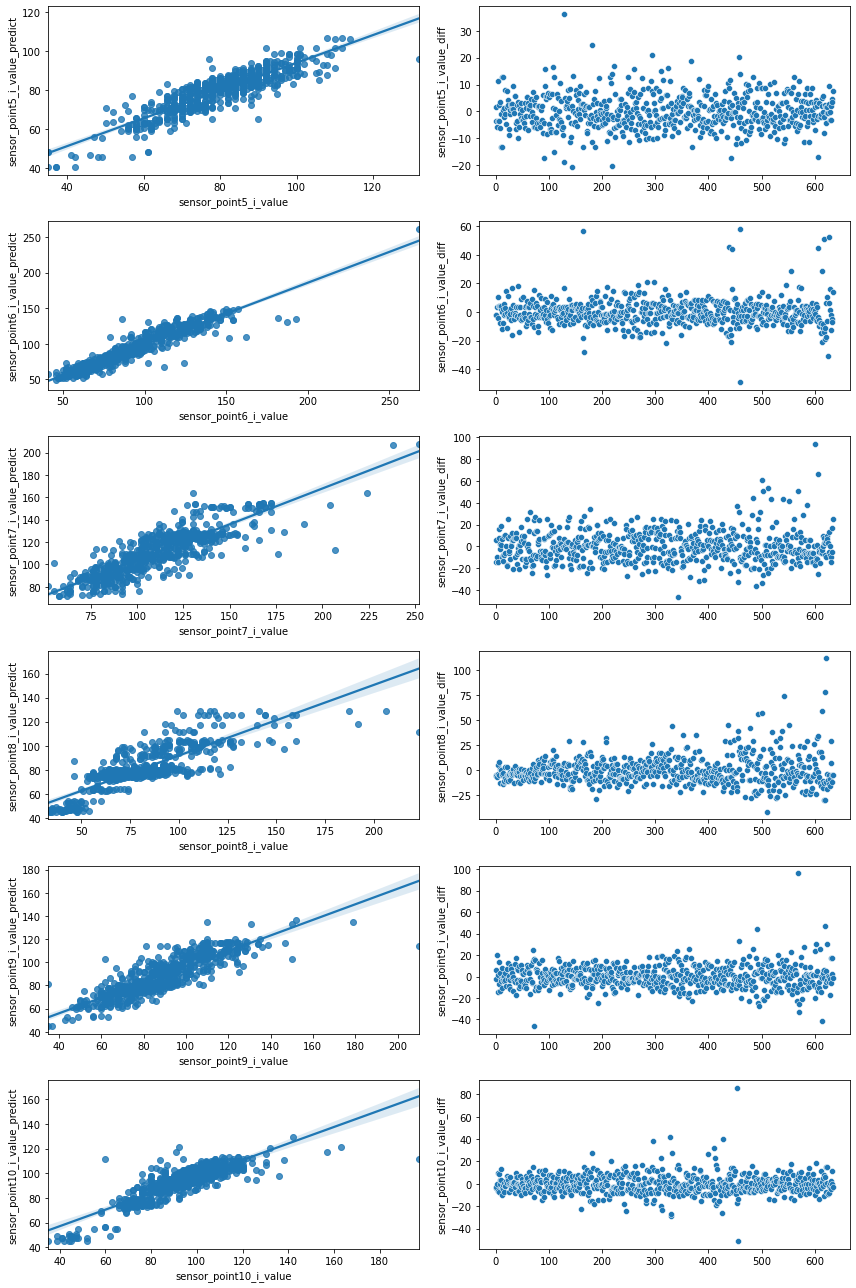

In [18]:
# 計算實際值跟預測值差異

data_T = Model_result # 資料類型
Model_ch = 'Cat' # 選擇 model

Y_predict_diff = data_y # 創建起始Table
for i in range(6):
    Y_predict_diff[data_y.columns.tolist()[i] + '_predict'] = data_T[Model_ch + '_' + data_y.columns.tolist()[i]]
    Y_predict_diff[data_y.columns.tolist()[i] + '_diff'] = data_T['Actual_' + data_y.columns.tolist()[i]]\
                                                            - data_T[Model_ch + '_' + data_y.columns.tolist()[i]]
# display(Y_predict_diff)

# seaborn呈現結果
fig, axes = plt.subplots(6, 2, figsize=(12, 18))

for i in range(6):
    # 預測值跟實際值分布狀況
    sns.regplot(x = data_y.columns.tolist()[i], 
                y = data_y.columns.tolist()[i] + '_predict', 
                data = Y_predict_diff, 
                ax=axes[i, 0])
    
    # 每筆資料的差異
    sns.scatterplot(x = Y_predict_diff.index,
                    y = data_y.columns.tolist()[i] + '_diff',
                    data = Y_predict_diff, 
                    ax=axes[i, 1])
    
    
plt.tight_layout()